# Project 2: Reproducibility in Natural Language Processing



## Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

In this notebook, we will compare two methods for creating topic models of the speeches we've been analyzing: Latent Dirichlet allocation (LDA) and BERTopic. To begin, we need to import our requisite packages.

### Imports

In **Part 2,** we downloaded spaCy's English language text processing model `en_core_web_sm` into our environment. If, for whatever reason, you have reached this point without downloading it, please do so now. While having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

In [1]:
# imports
import pandas as pd
import spacy
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

nlp = spacy.load("en_core_web_sm")

/home/jovyan/.local/share/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data

In [2]:
sou = pd.read_csv("data/SOTU.csv")

### LDA

LDA's "bag-of-words" approach is much more sensitive to text preprocessing, so the function below uses spaCy to tokenize the text; cut tokens down to their semantic "root" (e.g., "runs" and "running" become "run"); and remove stop words, punctiation, and spaces.

In [3]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [4]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

In [5]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5) # remove both highly common and rare tokens
corpus = [dictionary.doc2bow(doc) for doc in processed_docs] # build a corpus 

In [6]:
# Train LDA model with 18 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, passes=10, random_state=42)

In [7]:
print("\n--- State of the Union LDA Topics ---") 
for idx, topic in lda_model.print_topics(-1): 
    print(f"Topic: {idx} \nWords: {topic}\n")


--- State of the Union LDA Topics ---
Topic: 0 
Words: 0.004*"cent" + 0.004*"june" + 0.004*"gold" + 0.003*"island" + 0.003*"silver" + 0.003*"bond" + 0.003*"method" + 0.003*"convention" + 0.003*"indian" + 0.003*"note"

Topic: 1 
Words: 0.008*"depression" + 0.007*"program" + 0.007*"recovery" + 0.006*"budget" + 0.006*"unemployment" + 0.006*"loan" + 0.006*"activity" + 0.006*"farm" + 0.005*"emergency" + 0.005*"cent"

Topic: 2 
Words: 0.008*"dictator" + 0.005*"expression" + 0.004*"british" + 0.004*"1914" + 0.003*"impressive" + 0.003*"actual" + 0.003*"revolution" + 0.003*"schedule" + 0.003*"continent" + 0.003*"partisanship"

Topic: 3 
Words: 0.008*"forest" + 0.007*"corporation" + 0.005*"judge" + 0.005*"wrong" + 0.005*"interstate" + 0.004*"employee" + 0.003*"bureau" + 0.003*"body" + 0.003*"mountain" + 0.003*"island"

Topic: 4 
Words: 0.017*"program" + 0.014*"soviet" + 0.009*"1980" + 0.009*"u.s." + 0.008*"area" + 0.007*"major" + 0.006*"goal" + 0.006*"commitment" + 0.006*"challenge" + 0.006*"nu

In [22]:
# print the topic distribution for the first speech
lda_model[corpus[0]]

[(11, np.float32(0.99942815))]

In [12]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()
ldavis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(ldavis, 'outputs/lda_visualization.html')
ldavis

### BERTopic
BERTopic is better at handling semantic richness—or the messiness of natural language—so to start we don't need to any text preprocessing. All we do is list each speech as a string.

In [15]:
docs = sou['Text'].to_list()

In [16]:
# train the model - this takes about 30 seconds
topic_model = BERTopic(min_topic_size=3)
topics, probs = topic_model.fit_transform(docs)
# remove stop words from the topics
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [17]:
# output the top 10 words for each topic
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,26,-1_new_world_congress_year,"[new, world, congress, year, government, years...",[\n[As delivered in person before a joint sess...
1,0,125,0_states_government_united_united states,"[states, government, united, united states, co...",[\nFellow Citizens of the Senate and of the Ho...
2,1,26,1_people_new_world_years,"[people, new, world, years, america, year, ame...","[\nMr. Speaker, Mr. President, my colleagues i..."
3,2,11,2_world_peace_nations_economic,"[world, peace, nations, economic, nation, nati...","[\nMr. President, Mr. Speaker, Members of the ..."
4,3,11,3_america_american_americans_people,"[america, american, americans, people, new, kn...","[\nMr. Speaker, Mr. Vice President, Members of..."
5,4,10,4_government_work_great_public,"[government, work, great, public, law, congres...",[\nTo the Senate and House of Representatives:...
6,5,10,5_new_america_people_americans,"[new, america, people, americans, help, americ...","[\nMadam Speaker, Mr. Vice President, Members ..."
7,6,5,6_america_people_americans_world,"[america, people, americans, world, security, ...","[\nThank you all. Madam Speaker, Vice Presiden..."
8,7,5,7_national_federal_reduction_public,"[national, federal, reduction, public, ought, ...",[\n[ As delivered in person before a joint ses...
9,8,5,8_bank_public_states_government,"[bank, public, states, government, country, su...",[\nFellow-Citizens of the Senate and House of ...


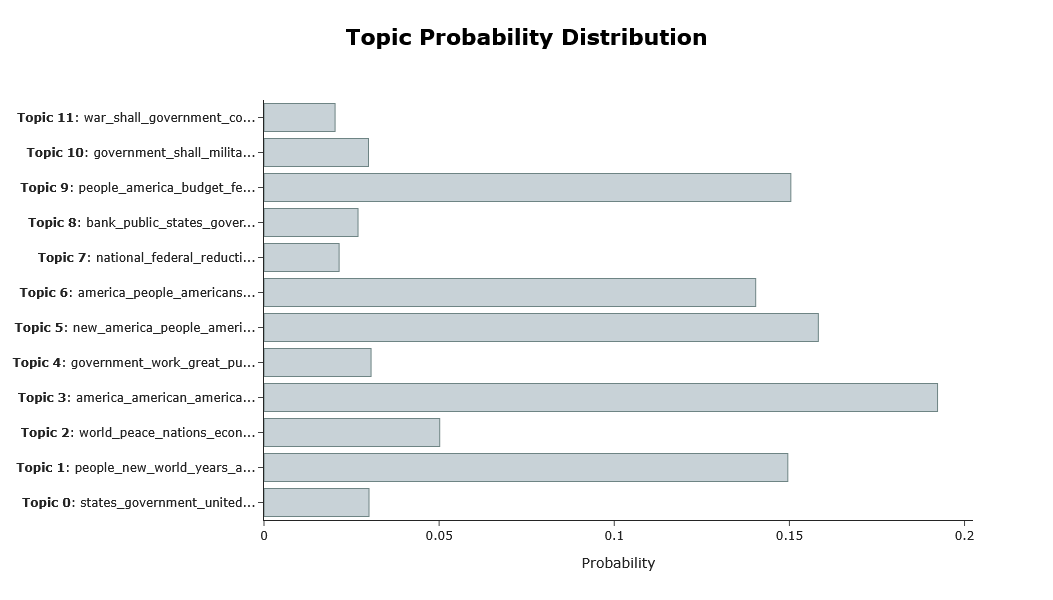

In [18]:
# output the topic distribution for the first speech
topic_distr, _ = topic_model.approximate_distribution(docs)
first_speech_distr = topic_model.visualize_distribution(topic_distr[0])
first_speech_distr.write_html("outputs/first_speech_distr.html")
first_speech_distr

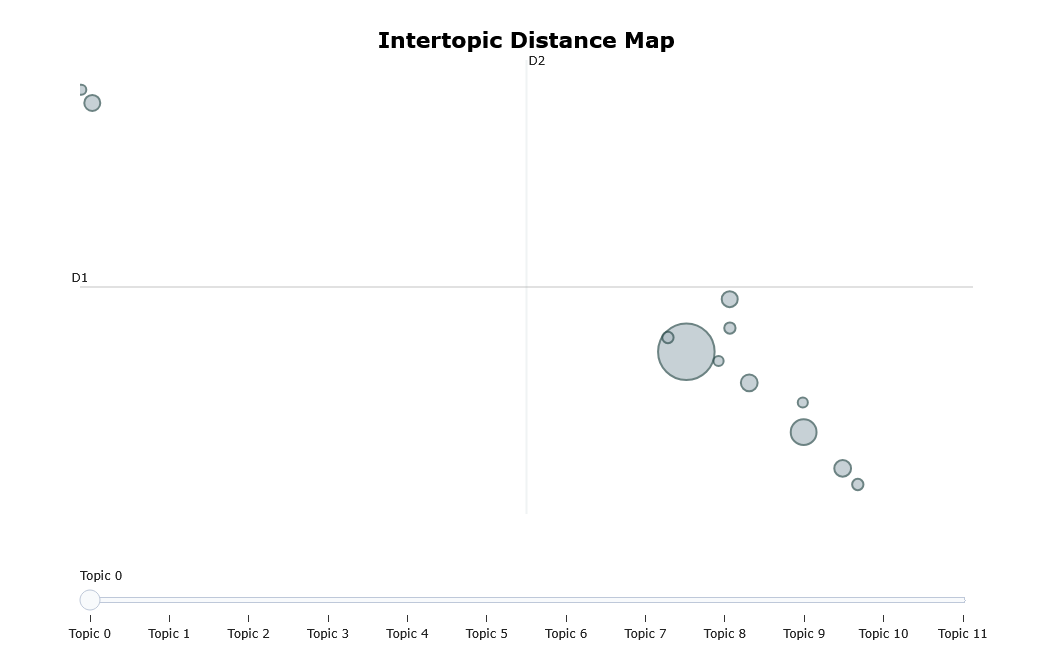

In [19]:
# run this cell to visualize the topics
topic_model.visualize_topics()
bertopicvis = topic_model.visualize_topics()
bertopicvis.write_html("outputs/bertopicvis.html")
bertopicvis